# Did the rise of smartphone usage in the U.S. cause an increase in car accidents?

## A Causal Inference Project


*This notebook contains the EDA for the project. The causal inference analysis was performed with R packages and are available in a `.Rmd` file.*

### Goals & Introduction

Driving around these days, it feels like there are more car crashes and more crash-related traffic than there used to be. It also feels like everyone is distracted all the time. Peering into other cars during traffic jams will almost always reveal the other drivers using their smart phones. It is well-known that distracted driving is dangerous, but most people still have their phones nearby when they are driving and will at least glance at them while they are stopped at red-lights or in stop-and-go traffic. 

Together, these observations led to the question: **Has smartphone usage caused a measurable increase in the number of traffic accidents in the U.S.?** 

This is a question that cannot be answered through experimentation, as it would be highly unethical to ask a group of people to use their phones when driving. However, causal inference methods may allow observational data to be used to determine whether smartphones caused an increase in the number of car accidents.


#### Data Sources

This analysis uses publicly available data collected by the National Highway Traffic Safety Administration (NHTSA) and the Pew Research Center. 
* The NHTSA collects data on car accidents that happen in the United States each month and classifies them as "Fatal", "Injury-causing", and "Property-damaging". The NHTSA data for this analysis was downloaded from: https://cdan.nhtsa.gov/query. 
* The Pew Research Center studies many facets of society, including the rising use of cell phones and smartphones. By conducting randomized surveys, they can estimate the proportion of adult Americans that own and use cellphones and/or smartphones. The cellphone surveys were launched in 2002, but the follow-up question about whether the cellphone being used is a smartphone was not added until 2011. These data were downloaded from: https://www.pewresearch.org/internet/fact-sheet/mobile/.  




### Load libraries and data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
%matplotlib inline 

In [2]:
crash_data = pd.read_csv("crash_by_month.csv") # annual crash data from NHTSA
phone_data = pd.read_csv("PEW_CellPhoneUsage.csv") # cellphone usage data from the Pew Research Center

### Data structure and characteristics 

In [3]:
crash_data.head() # look at the top 5 rows of the crash data to get a feel for the structure of the dataframe

,year,January,February,March,April,May,June,July,August,September,October,November,December,Type,Population
0,2006,2931,2695,3042,3138,3345,3383,3527,3474,3348,3462,3168,3135,Fatal,299398484
1,2007,2732,2618,3092,3041,3312,3281,3460,3325,3235,3325,3066,2948,Fatal,301621157
2,2008,2575,2586,2549,2722,2887,3029,3018,3224,2860,3063,2829,2830,Fatal,304059724
3,2009,2377,2167,2349,2592,2780,2750,2787,2865,2650,2622,2512,2411,Fatal,307006550
4,2010,2101,1830,2213,2552,2704,2569,2852,2825,2799,2827,2587,2437,Fatal,309327143


In [4]:
crash_data.info() # find out the size of the crash dataframe, types of data, and whether there are missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year        45 non-null     int64 
 1   January     45 non-null     int64 
 2   February    45 non-null     int64 
 3   March       45 non-null     int64 
 4   April       45 non-null     int64 
 5   May         45 non-null     int64 
 6   June        45 non-null     int64 
 7   July        45 non-null     int64 
 8   August      45 non-null     int64 
 9   September   45 non-null     int64 
 10  October     45 non-null     int64 
 11  November    45 non-null     int64 
 12  December    45 non-null     int64 
 13  Type        45 non-null     object
 14  Population  45 non-null     int64 
dtypes: int64(14), object(1)
memory usage: 5.4+ KB


The crash data consists of 15 columns and 45 rows, and is a mixed long/wide dataframe: `year`, `Type` (of crash), and `Population` are in long format, while the number of crashes per month is in wide format with one column for each month. Luckily, there are no missing data to contend with.

To get this dataframe ready for plotting and analysis, it will need to be converted to fully long format. In addition, the dates (month and year) will need to be formatted, the total number of crashes for each month/year will need to be computed (sum the number of each crash type: "Fatal", "Injury-causing", and " Property-damaging"), and the total number of crashes per month/year will need to be normalized to the total population that year.

In [5]:
phone_data.head() # look at the top 5 rows of the cellphone data to get a feel for the structure of the dataframe

,Date,Cellphone,Smartphone
0,10/27/02,62,NaN
1,11/30/04,65,NaN
2,2/9/05,66,NaN
3,12/31/05,67,NaN
4,3/28/06,66,NaN


In [ ]:
phone_data.info() # find out the size of the cellphone dataframe, types of data, and whether there are missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        64 non-null     object 
 1   Cellphone   64 non-null     int64  
 2   Smartphone  29 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ KB


The cellphone data consists of 3 columns and 64 rows. The `Date` column will need to be converted to the date data type. The `Cellphone` and `Smartphone` columns are both percents of the adult American population and do not need to be adjusted. There are quite a few missing data points in the `Smartphone` column.


### Data Formatting 

#### Crash Data

The crash data requires a fair bit of formatting. Tasks include: 

- Pivot from a wide data frame to a long data frame 
- Format the date column 
- Sum the different types of crashes for each month 
- Normalize the number of crashes to the population 
- Add a column designating the season of the year 

First up, the dataframe will be converted to a fully long format:

In [6]:
long_crash_data = pd.melt(crash_data, id_vars=['year', 'Population', 'Type']) # pivot the dataframe from wide to long
long_crash_data.rename(columns={ "variable" : "Month"}, inplace = True) # change the name of the column with months to be "Month"
long_crash_data.head()

,year,Population,Type,Month,value
0,2006,299398484,Fatal,January,2931
1,2007,301621157,Fatal,January,2732
2,2008,304059724,Fatal,January,2575
3,2009,307006550,Fatal,January,2377
4,2010,309327143,Fatal,January,2101


Now the crash data is in a fully long format.

Next, the date column will be formatted:

In [ ]:
long_crash_data["Month_Year"] = long_crash_data["Month"] + long_crash_data["year"].astype(str) # concatenate month and year into one column

long_crash_data["Date"] = pd.to_datetime(long_crash_data['Month_Year']) # convert month and year to date format

long_crash_data.drop(columns = ["year", "Month_Year"], inplace = True) # clean-up old columns

print(long_crash_data.head())
print(long_crash_data.info())

   Population   Type    Month  value       Date
0   299398484  Fatal  January   2931 2006-01-01
1   301621157  Fatal  January   2732 2007-01-01
2   304059724  Fatal  January   2575 2008-01-01
3   307006550  Fatal  January   2377 2009-01-01
4   309327143  Fatal  January   2101 2010-01-01
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Population  540 non-null    int64         
 1   Type        540 non-null    object        
 2   Month       540 non-null    object        
 3   value       540 non-null    int64         
 4   Date        540 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 21.2+ KB
None


Now there is a `Date` column that includes the month and year is the data type `datetime64`.

Next, the total number of crashes (including all three types) will be computed for each month:

In [ ]:
summed_crash_data = long_crash_data.groupby(['Date', 'Population', 'Month'], as_index = False)["value"].sum() # sum the different types of crashes for each date

summed_crash_data.head()

,Date,Population,Month,value
0,2006-01-01,299398484,January,506512
1,2006-02-01,299398484,February,461160
2,2006-03-01,299398484,March,478828
3,2006-04-01,299398484,April,466287
4,2006-05-01,299398484,May,503526


There is no longer a `Type` column and the `value` (number of crashes) was summed for all three types of crashes for each date.

Next, the number of crashes will be normalized to population size (per 100,000 people):


In [ ]:
summed_crash_data["Pop_100k"] = summed_crash_data["Population"] / 100000 # get the population as number of 100s of thousands 
summed_crash_data["Crashes_per_100k"] = summed_crash_data["value"] / summed_crash_data["Pop_100k"] # normalize the crash counts to per 100 thousand people


summed_crash_data.drop(columns = ["Population", "value", "Pop_100k"], inplace = True) # clean-up old columns

summed_crash_data.head()

,Date,Month,Crashes_per_100k
0,2006-01-01,January,169.176541
1,2006-02-01,February,154.028836
2,2006-03-01,March,159.930002
3,2006-04-01,April,155.741270
4,2006-05-01,May,168.179208


Finally, another column, `Season` will be added based on the `Month` column. By adding this column it will be possible to test whether more crashes occur in certain seasons.

In [ ]:
# create a dictionary designating each month to one season
season_dict = {
    'December' : 'Winter',
    "January" :"Winter",
    "February" :"Winter",
    "March" :"Spring",
    "April": "Spring",
    "May" :"Spring",
    "June": "Summer",
    "July": "Summer",
    "August" :"Summer",
    "September" :"Fall",
    "October": "Fall",
    "November" :"Fall"
}

summed_crash_data["Season"] = summed_crash_data['Month'].map(season_dict) # create new column 'Season' based on the month
summed_crash_data.drop(columns = ["Month"], inplace = True) # clean-up old columns

print(summed_crash_data.head())
print(summed_crash_data.info())

        Date  Crashes_per_100k  Season
0 2006-01-01        169.176541  Winter
1 2006-02-01        154.028836  Winter
2 2006-03-01        159.930002  Spring
3 2006-04-01        155.741270  Spring
4 2006-05-01        168.179208  Spring
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              180 non-null    datetime64[ns]
 1   Crashes_per_100k  180 non-null    float64       
 2   Season            180 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 4.3+ KB
None


The formatted crash dataframe has 3 columns and 180 rows. The `Crashes_per_100k` has the total number of car crashes (regardless of type) for each month of every year from 2006 to 2020 normalized to population.

#### Smartphone data

The smartphone data requires considerably less formatting. The main task is to format the date column as `datetime64`: 

In [ ]:
phone_data['Date'] = pd.to_datetime(phone_data['Date'])

In [ ]:
phone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        64 non-null     datetime64[ns]
 1   Cellphone   64 non-null     int64         
 2   Smartphone  29 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.6 KB


The formatted cellphone data still has 3 columns and 64 rows. Additionally, there is still missing data in the `Smartphone` column.

### Plotting the data

#### Crash Data

A scatter plot of the normalized crash data over time will reveal any outliers that need to be considered and will show general trends in the number of car crashes over time.

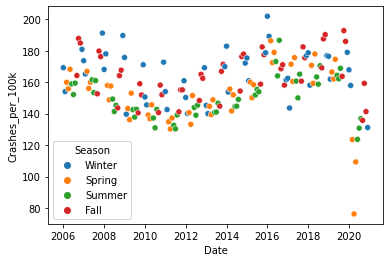

In [ ]:
plt.figure()
sns.scatterplot(x = 'Date', y = 'Crashes_per_100k', hue = "Season",
                data = summed_crash_data)
plt.show()

The plot shows a sharp decline in the numbers of car crashes in 2020. Clearly, the COVID-19 pandemic, which started in February/March of 2020 in the U.S., had a substantial impact on the number of people driving and crashing. The year 2020 is an outlier and will be removed from future analysis:

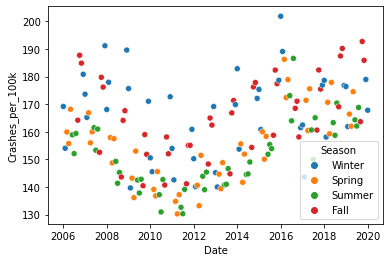

In [ ]:
summed_crash_data = summed_crash_data[(summed_crash_data['Date'] <= '2020-1-01')] # filter dates after January 2020

plt.figure()
sns.scatterplot(x = 'Date', y = 'Crashes_per_100k', hue = "Season", 
                data = summed_crash_data)
plt.show()

Once the outlier year is removed, the overall trend in the crash rate is much more apparent: the number of crashes per 100k people appears to decrease steadily from 2006 until about 2011, when the trend reverses direction and the number of crashes per 100k people starts steadily increasing. There also seems to be a seasonal effect, with more crashes happening in the Fall and Winter than the Spring and Summer. However, the overall trend of falling crash rates before 2011 and rising crash rates after 2011 appears to hold for all four seasons.

Now that the dataset is fully cleaned, it can be exported as a `.csv` file that can later be used for causal inference in R: 

In [ ]:
summed_crash_data.to_csv("crash_by_month_cleaned.csv", index = False)

#### Smartphone Data

Although the cellphone dataset has information about total cellphone usage as well as smartphone usage, the goal of this analysis is focused on determining whether smartphone usage, specifically, caused an increase in car acccidents in the U.S.

A scatterplot will show the overall trend in smartphone usage over time:

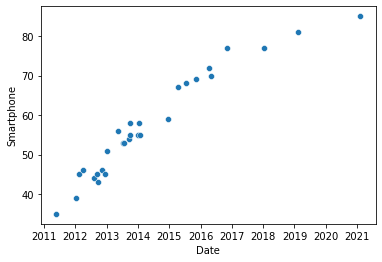

In [ ]:
plt.figure()
sns.scatterplot(x = 'Date', y = 'Smartphone', data = phone_data)
plt.show()

The percentage of American adults that reported using a smartphone increased steadily from 2011, when smartphone usage first started being reported, to about 2017, when usage continued to increase but at an apparently slower rate. Unfortunately, the data and the plot do not show when *exactly* that smartphone usage started taking off. The first iPhone was released in 2007, but did not become popular for a few years after its release. The first Android smartphone was released in 2008, and similarly experienced some lagtime before it gained popularity. However, 2011, with smartphone usage reaching 1/3 of the population and the recognition that the phenomenon is significant enough to record by the Pew Research Center, is a significant year. Therefore, 2011 will be used as the cutpoint in the ensuing causal inference analysis. As this is the key insight from this dataset, it does not need to be exported for further analysis with R.

### Hypothesis Testing

The scatter plot of the crash data revealed a potential trend in the data: it looked like there were more crashes in the fall and winter than in the spring and summer, regardless of year. This is a hypothesis that can be tested with a oneway ANOVA or analysis of variance.

In [ ]:
from scipy.stats import f_oneway # import function for oneway ANOVA

In [ ]:
#subset the crash rates by season
winter = summed_crash_data[summed_crash_data['Season']== 'Winter']['Crashes_per_100k']
spring = summed_crash_data[summed_crash_data['Season']== 'Spring']['Crashes_per_100k']
summer = summed_crash_data[summed_crash_data['Season']== 'Summer']['Crashes_per_100k']
fall = summed_crash_data[summed_crash_data['Season']== 'Fall']['Crashes_per_100k']

In [ ]:
anova_result = f_oneway(winter,spring,summer,fall) #perform the oneway analysis of variance on crash rate based on season
print(anova_result)

F_onewayResult(statistic=11.931927554935433, pvalue=4.119913700411912e-07)


In this case, the null hypotheses was that season has no impact on crash rate. Since the *p*-value is so low (much lower than the traditional cut-off of 0.05), the null hypothesis is rejected. The relatively high *F* statistic provides further support for our hypothesis. As a result, it can be concluded that season does impact crash rate. 

The ANOVA alone cannot indicate which seasons have different crash rates. But since the ANOVA results were statistically significant, it is appropriate to apply an *ad hoc* test, such as Tukey's honestly significant difference (HSD) test that can determine which seasons have statistically significant crash rates from eachother. 

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd #import the function for a pairwise Tukey HSD test

In [ ]:
tukeyHSD_results = pairwise_tukeyhsd(endog=summed_crash_data['Crashes_per_100k'], #perform the pairwise Tukey HSD test
                          groups=summed_crash_data['Season'],
                          alpha=0.05) # the p-value cut-off for statistical significance is defined as 0.05
print(tukeyHSD_results)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
  Fall Spring -10.6271 0.0041 -18.6577 -2.5964   True
  Fall Summer -14.3698  0.001 -22.4005 -6.3391   True
  Fall Winter   0.5477    0.9  -7.4362  8.5315  False
Spring Summer  -3.7427 0.6073 -11.7734   4.288  False
Spring Winter  11.1748 0.0021   3.1909 19.1586   True
Summer Winter  14.9175  0.001   6.9336 22.9013   True
-----------------------------------------------------


Here, the null hypothesis is that there is no difference in crash rate between the two seasons being compared. Based on the results, this null hypothesis can be rejected for Fall/Spring, Fall/Summer, Spring/Winter, and Summer/Winter. To sum up, the crash rate in Fall and Winter is significantly different than in Spring and Summer.